## Python vs C/C++ implementation

We observe **300x speedup**

In [1]:
#https://libpqcrypto.org/install.html
import pqcrypto

#https://github.com/nakov/PyNewHope
from pynewhope import newhope

In [2]:
pk,sk = pqcrypto.kem.newhope1024cca.keypair() #publickey, secretkey
c,kB = pqcrypto.kem.newhope1024cca.enc(pk)
kA = pqcrypto.kem.newhope1024cca.dec(c,sk)
assert kB == kA

In [3]:
sk,pk = newhope.keygen()
kB,c = newhope.sharedB(pk)
kA = newhope.sharedA(c, sk)
assert kB==kA

In [4]:
def convert_key(sharedKey):
    return ''.join([chr(byte) for byte in sharedKey])

In [5]:
def newhope_ex_pqcrypto():
    pk,sk = pqcrypto.kem.newhope1024cca.keypair()
    c,kB = pqcrypto.kem.newhope1024cca.enc(pk)
    kA = pqcrypto.kem.newhope1024cca.dec(c,sk)
    
def newhope_ex_python():
    sk,pk = newhope.keygen()
    kB,c = newhope.sharedB(pk)
    kA = newhope.sharedA(c, sk)

In [6]:
%%timeit
newhope_ex_pqcrypto()

190 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%%timeit
newhope_ex_python()

58.1 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Comparison of different methods

In [8]:
import time
import gc

def key_ex(algo,name):
    start=time.time()
    reps=10**2
    for _ in range(reps):
        pk,sk = algo.keypair()
        c,kB = algo.enc(pk)
        kA = algo.dec(c,sk)
    assert kB == kA
    delta=(time.time()-start)/reps
    return name,len(pk),delta

In [9]:
#all produce 32 bytes session key
todo='''firesaber kindi256342
        kyber1024 kyber512 kyber1024 kyber768
        lightsaber mceliece6960119 mceliece8192128
        newhope1024cca newhope512cca
        ntruhrss701 ntrulpr4591761
        ramstakers216091 ramstakers756839
        saber sntrup4591761'''.split()

In [10]:
%%time
gc.disable()
stats=[ key_ex(algo,name) for name,algo in pqcrypto.kem.__dict__.items() if name in todo] 
gc.enable()

CPU times: user 5min 1s, sys: 31.7 ms, total: 5min 1s
Wall time: 5min 1s


In [11]:
import pandas as pd

df = pd.DataFrame(stats)
df.columns=['name','pub_size','speed']
df.set_index('name',inplace=True)
df

,pub_size,speed
name,,
firesaber,1312,0.000415
kindi256342,1184,0.000319
kyber1024,1440,0.000155
kyber512,736,0.000077
kyber768,1088,0.000139
lightsaber,672,0.000138
mceliece6960119,1047319,1.695919
mceliece8192128,1357824,1.229356
newhope1024cca,1824,0.000188


In [12]:
df=df.drop(['mceliece6960119','mceliece8192128','ramstakers216091','ramstakers756839'])

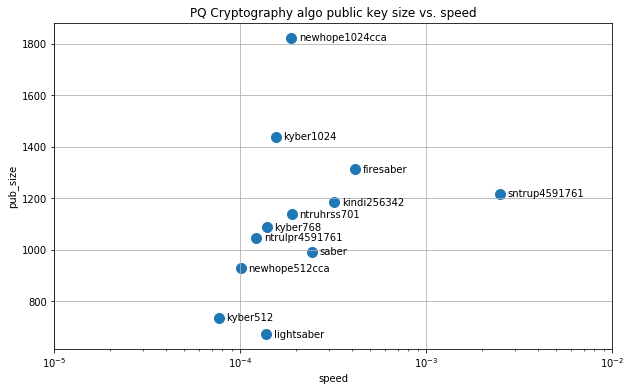

In [14]:
ax=df.plot('speed','pub_size', kind='scatter',logx=True,grid=True,figsize=(10,6),s=100)
ax.set_title("PQ Cryptography algo public key size vs. speed")
ax.set_xlim(10**-5,10**-2)
# loop through each x,y pair
for i,j,name in zip(df.speed,df.pub_size,df.index):
    ax.annotate(name,  xy=(i+i*.1, j-12))